<h2>
Given the sample data below, assess how the time between a person's start and end date (i.e. 'duration') varies based on the attributes of the person.
</h2>

<p style='font-size: 14pt;'>
First we will load necessary libraries and read the data tables into pandas. 
</p>

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline 

#set default figure size and use custom style
plt.rcParams['figure.figsize'] = (12, 10)
plt.style.use('ggplot')

In [318]:
persons_url = 'http://pastebin.com/raw/sv4cFgts'
events_url = 'http://pastebin.com/raw/tQ9r5dBg'

#read the two tables as DataFrames
persons_df = pd.read_csv(persons_url, index_col='person_id')
events_df = pd.read_csv(events_url, parse_dates=['event_date'], index_col='event_id')

<p style='font-size: 14pt;'> 
Before calculating the durations, we should make sure that each person has a 'start' and 'end' event.  We can use pandas to inspect the number of events for each person, which reveals that a subset of persons do not have both 'start' and 'end' events: 
<p>

In [319]:
print events_df.groupby('person_id').size().to_frame('count')

           size
person_id      
1             2
2             2
3             2
4             2
5             2
6             2
7             2
8             2
9             1
10            2
11            2
12            2
13            2
14            1
15            2
16            2
17            2
18            2


<p style='font-size: 14pt;'> 
There are a number of ways we could deal with this missing data, but in this case we will simply disregard those persons that do not have a 'start' and 'end' event.  Next, we can compute the duration for each person and add this column to the 'persons' table. 
</p>

In [320]:
#we need both a 'start' and 'end' date to compute duration, so filter out persons without two entries
events_df = events_df.groupby('person_id').filter(lambda group: len(group) == 2)

#group by 'person_id' and compute duration
durations = events_df.groupby('person_id').apply(lambda group: (group.event_date.max() - group.event_date.min()).days)

#join the durations with persons_df
persons_df = persons_df.join(durations.to_frame('duration'), how='right')

<p style='font-size: 14pt;'> 
It may be helpful to view the distribution of the durations before performing analysis.  Here we can use a boxplot to view the median values, interquartile range, and outlier points (indicated by blue circles).  If we plot the data on a linear scale (on the left), we only see outlier points (the actual box is too small to view), which suggests that there are significant outliers.  Plotting the data on a log scale (on the right) confirms this suspicion:
</p>

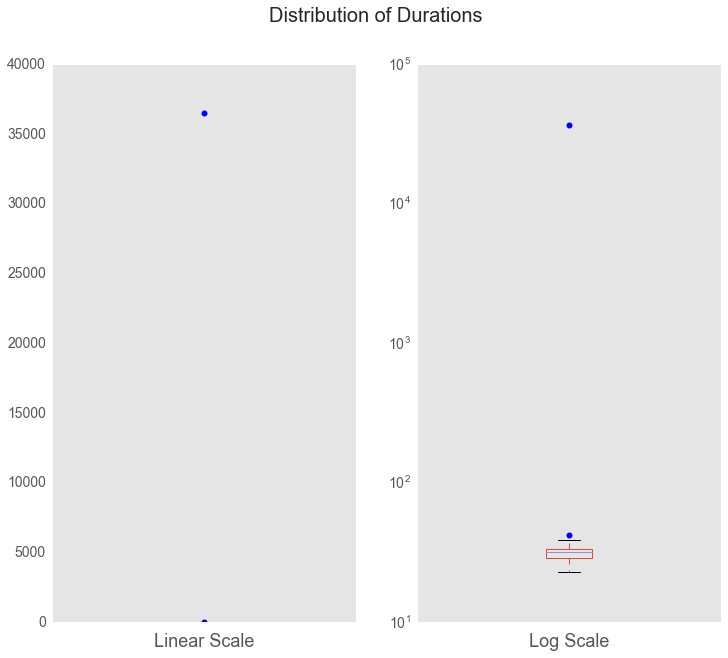

In [321]:
common_args = { 'y': 'duration',
         'kind': 'box',
         'sym': 'o',
         'grid': False
        }

fig, (ax1, ax2) = plt.subplots(1, 2)

persons_df.plot(logy=False, 
                ax=ax1,      
                **common_args)

persons_df.plot(logy=True,
                ax=ax2, 
                **common_args)

fig.suptitle('Distribution of Durations', fontsize=20)

ax1.set_xticklabels('')
ax1.set_xlabel('Linear Scale', fontsize=18)

ax2.set_xticklabels('')
ax2.set_xlabel('Log Scale', fontsize=18);

<p style='font-size: 14pt;'> 
Particularly with smaller datasets, outliers should be investigated to determine if such anomalies are due to human error.  In this case, the most significant outlier had a 'start' date of '1915', which strongly suggests that this data was entered incorrectly.  However, for the purposes of this exercise we will simply filter out outliers:
</p>

In [322]:
#get first and third quartiles
q1, q3 = persons_df.duration.quantile([0.25, 0.75])

#define interquartile range (iqr)
iqr = q3 - q1

#in the case of Tukey's boxplots, outliers are defined as:
not_outlier = lambda val: (q1 - 1.5 * iqr) <= val <= (q3 + 1.5 * iqr)

#filter out outliers
persons_df = persons_df[persons_df.duration.apply(not_outlier)]

print persons_df

          region group  duration
person_id                       
1           west     B        32
2           west     A        26
3           west     A        30
5           east     B        27
6           west     C        39
7           west     B        34
8           east     C        32
10          east     A        28
11          east     C        33
12          east     A        29
13          east     C        32
15          west     A        23
16          east     A        32
17          west     C        32


<p style='font-size: 14pt;'> 
Now we can perform the actual analysis! Since our goal is to examine the effect of two categorical variables ('group' and 'region') on a continuous variable 'duration', it is helpful to view the differences in the distribution of 'duration' for each of these categories: 
</p>

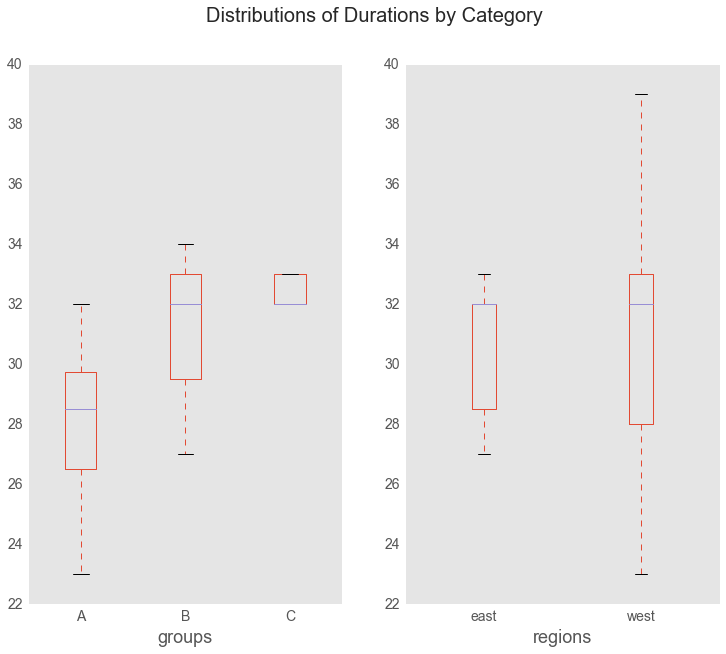

In [323]:
common_args = {
         'grid': False
        }

fig, (ax1, ax2) = plt.subplots(1, 2)

persons_df.boxplot(by='group', ax=ax1, **common_args)

persons_df.boxplot(by='region', ax=ax2, **common_args)

fig.suptitle('Distributions of Durations by Category', fontsize=20)

ax1.set_title('')
ax1.set_xlabel('groups', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.set_title('')
ax2.set_xlabel('regions', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14);

<p style='font-size: 14pt;'> 
To more formally test the significance of these categorical variables on the dependent variable 'duration', we can use two-way ANOVA.  The following gives us the ANOVA results for each categorical variable, as well as the interaction between the two.  We can see in the results table that 'group' is the only variable with a significant p value (.027), which is consistent with the observation in the charts above that 'group' shows more inter-category variation.  
</p>

In [336]:
model = ols('duration ~ C(group) * C(region)', data=persons_df).fit()
anova_results = sm.stats.anova_lm(group_model, typ=2)

print anova_results

                       sum_sq   df         F    PR(>F)
C(group)            87.700141  2.0  5.798356  0.027773
C(region)            2.328713  1.0  0.307929  0.594125
C(group):C(region)  50.371287  2.0  3.330333  0.088664
Residual            60.500000  8.0       NaN       NaN


<p style='font-size: 14pt;'> 
These results are promsing in suggesting that there is a strong relationship between a person's group membership and their duration, but it should be noted that the sample size is here is really too small to make any conclusions. The following output shows the count for each grouping along each categorical variable ('group' and 'region'), as well as the count for the groupings on the combinations of these two. 
</p>

In [343]:
groups = ['group', 'region', ['group', 'region']]

for group in groups:
    print 'Counts for grouping on %s' % str(group)
    print persons_df.groupby(group).size().to_frame('count'), '\n'

Counts for grouping on group
       count
group       
A          6
B          3
C          5 

Counts for grouping on region
        count
region       
east        7
west        7 

Counts for grouping on ['group', 'region']
              count
group region       
A     east        3
      west        3
B     east        1
      west        2
C     east        3
      west        2 

